**Naive Bayes**

We will be using Naive Bayes for sentiment analysis on tweets. Given a tweet, you will decide if it has a positive sentiment or a negative one. Specifically you will:

1. Train a naive bayes model on a sentiment analysis task

2. Test using your model

3. Compute ratios of positive words to negative words

4. Do some error analysis

5. Predict on your own tweet

In [1]:
import pdb
from nltk.corpus import stopwords, twitter_samples
import numpy as np
import pandas as pd
import nltk
import string
from nltk.tokenize import TweetTokenizer
from os import getcwd


In [3]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import re
import string

def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

In [4]:
def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [74]:
def lookup(freqs, word, label):
    '''
    Input:
        freqs: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Output:
        n: the number of times the word with its corresponding label appears.
    '''
    n = 0  # freqs.get((word, label), 0)

    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]

    return n

In [68]:
def test_lookup(func):
    freqs = {('sad', 0): 4,
             ('happy', 1): 12,
             ('oppressed', 0): 7}
    word = 'happy'
    label = 1
    if func(freqs, word, label) == 12:
        return 'SUCCESS!!'
    return 'Failed Sanity Check!'

In [75]:
test_lookup(lookup)

'SUCCESS!!'

In [6]:
# get the sets of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

train_pos = all_positive_tweets[:4000]
train_neg = all_negative_tweets[:4000]

test_pos = all_positive_tweets[4000:]
test_neg = all_negative_tweets[4000:]

train_x = train_pos + train_neg
test_x = test_pos + test_neg


# avoid assumptions about the length of all_positive_tweets
train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

**Part 1: Process the Data**

For any machine learning project, once you've gathered the data, the first step is to process it to make useful inputs to your model.

Remove noise: You will first want to remove noise from your data -- that is, remove words that don't tell you much about the content. These include all common words like 'I, you, are, is, etc...' that would not give us enough information on the sentiment.

We'll also remove stock market tickers, retweet symbols, hyperlinks, and hashtags because they can not tell you a lot of information on the sentiment.

You also want to remove all the punctuation from a tweet. The reason for doing this is because we want to treat words with or without the punctuation as the same word, instead of treating "happy", "happy?", "happy!", "happy," and "happy." as different words.

Finally you want to use stemming to only keep track of one variation of each word. In other words, we'll treat "motivation", "motivated", and "motivate" similarly by grouping them within the same stem of "motiv-".

In [8]:
custom_tweet = "RT @Twitter @chapagain Hello There! Have a great day. :) #good #morning http://chapagain.com.np"
print(process_tweet(custom_tweet))

['hello', 'great', 'day', ':)', 'good', 'morn']


In [24]:
def count_tweets(result, tweets, ys):
    
    for y, tweet in zip(ys, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            
            # If the key exists in the dictionary, increament the count
            if pair in result:
                result[pair] += 1
                
            else:
                result[pair] = 1
                
    return result

In [25]:
# Testing your function


result = {}
tweets = ['i am happy', 'i am tricked', 'i am sad', 'i am tired', 'i am tired']
ys = [1, 0, 0, 0, 0]
count_tweets(result, tweets, ys)


{('happi', 1): 1, ('trick', 0): 1, ('sad', 0): 1, ('tire', 0): 2}

In [22]:
tweets = ['i am happy', 'i am tricked', 'i am sad', 'i am tired', 'i am tired']
for tweet in tweets:
    print(process_tweet(tweet))


['happi']
['trick']
['sad']
['tire']
['tire']


**Part 2: Train your model using Naive Bayes**

Naive bayes is an algorithm that could be used for sentiment analysis. It takes a short time to train and also has a short prediction time

1. The first part of training a naive bayes classifier is to identify the number of classes that you have.

2. You will create a probability for each class. P(Dpos) is the probability that the document is positive. P(Dneg) is the probability that the document is negative. Use the formulas as follows and store the values in a dictionary:

P(Dpos) = Dpos / D               

P(Dneg) = Dneg / D

Where D is the total number of documents, or tweets in this case, Dpos is the total number of positive tweets and Dneg is the total number of negative tweets.

In [26]:
freqs = count_tweets({}, train_x, train_y)


In [55]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of tweets
        train_y: a list of labels correponding to the tweets (0,1)
    Output:
        logprior: the log prior. 
        loglikelihood: the log likelihood of you Naive bayes equation. 
    '''
    
    loglikelihood = {}
    logprior = 0
    
    # Calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()] )
    V = len(vocab)
    
    # Calculate N_pos and N_neg
    N_pos = N_neg = 0
    
    for pair in freqs.keys():
        if pair[1] > 0:
            N_pos += 1
        else:
            N_neg +=1
            
    
    # Calculate D, the number of documents
    D = len(train_x)
    
    # Calculate D_pos, the number of positive Documents
    D_pos = sum(train_y)
    
    # Calculate D_neg, the number of negative documents
    D_neg = D - D_pos
    
    # Calculate loprior
    logprior = np.log(D_pos) - np.log(D_neg)
    
    # For each word in vocabulary...
    for word in vocab:
        # getting the positive and negative frequency of the word
        freq_pos = freqs[(word, 1.0)] if (word, 1.0) in freqs.keys() else  0
        freq_neg = freqs[(word, 0.0)] if (word, 0.0) in freqs.keys() else 0
        
        
        # Calculate the probability that each word is positive, and negative
        p_w_pos = freq_pos + 1 / N_pos + V
        p_w_neg = freq_neg + 1 / N_neg + V
        
        # Calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos / p_w_neg)
        
    return logprior, loglikelihood

In [56]:
logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)
print(logprior)
print(len(loglikelihood))

0.0
9085


In [52]:
vocab = set([pair[0] for pair in freqs.keys()] )
vocab

{'sad',
 "they'r",
 'wnt',
 'quit',
 'üò¨',
 'box',
 'bierc',
 'sheskindahot',
 'rear-end',
 'pixel',
 '48id',
 'kapatidkongpogi',
 'ily.melani',
 'afterschool',
 'melt',
 'choir',
 'bawi',
 'wendi',
 'today',
 'mysumm',
 'sharp',
 '2-4',
 'prima',
 'poootek',
 'rlyyi',
 'asid',
 'socent',
 'joim',
 'bush',
 'explain',
 'congratz',
 'fought',
 'kati',
 'billionair',
 'kathryn',
 'pong',
 'anniversari',
 'pandora',
 'naw',
 "php'",
 'ohh',
 'oo',
 '76x',
 'grasp',
 'tologooo',
 'bikini',
 'briefli',
 '645k',
 '50p',
 'x14',
 'mamaya',
 'undead',
 'minal',
 'rape',
 'cortez',
 'id',
 'lolll',
 'lart',
 'worri',
 'niamh',
 'url',
 'nugget',
 'occur',
 '19',
 'hsr',
 'achiev',
 '6g',
 'justiÃán',
 'fashion',
 'bad',
 'tradit',
 'asf',
 'dublin',
 'onair',
 'grim',
 '10/10',
 'soamaz',
 'dont',
 'brb',
 'vishwa',
 'intoler',
 '22stan',
 'event',
 "taeyeon'",
 'torrentialrain',
 'cereal',
 'warmest',
 'pyjama',
 'unni',
 'refurbish',
 'sunjam',
 'tone',
 'edsa',
 'toptravelcentar',
 'rehash

In [45]:
for word in freqs.keys():
    print(word)

('followfriday', 1.0)
('top', 1.0)
('engag', 1.0)
('member', 1.0)
('commun', 1.0)
('week', 1.0)
(':)', 1.0)
('hey', 1.0)
('jame', 1.0)
('odd', 1.0)
(':/', 1.0)
('pleas', 1.0)
('call', 1.0)
('contact', 1.0)
('centr', 1.0)
('02392441234', 1.0)
('abl', 1.0)
('assist', 1.0)
('mani', 1.0)
('thank', 1.0)
('listen', 1.0)
('last', 1.0)
('night', 1.0)
('bleed', 1.0)
('amaz', 1.0)
('track', 1.0)
('scotland', 1.0)
('congrat', 1.0)
('yeaaah', 1.0)
('yipppi', 1.0)
('accnt', 1.0)
('verifi', 1.0)
('rqst', 1.0)
('succeed', 1.0)
('got', 1.0)
('blue', 1.0)
('tick', 1.0)
('mark', 1.0)
('fb', 1.0)
('profil', 1.0)
('15', 1.0)
('day', 1.0)
('one', 1.0)
('irresist', 1.0)
('flipkartfashionfriday', 1.0)
('like', 1.0)
('keep', 1.0)
('love', 1.0)
('custom', 1.0)
('wait', 1.0)
('long', 1.0)
('hope', 1.0)
('enjoy', 1.0)
('happi', 1.0)
('friday', 1.0)
('lwwf', 1.0)
('second', 1.0)
('thought', 1.0)
('‚Äô', 1.0)
('enough', 1.0)
('time', 1.0)
('dd', 1.0)
('new', 1.0)
('short', 1.0)
('enter', 1.0)
('system', 1.0)
('she

**Part 3: Test your naive bayes**

Now that we have the logprior and loglikelihood, we can test the naive bayes function by making predicting on some tweets!

1. The function takes in the tweet, logprior, loglikelihood.

2. It returns the probability that the tweet belongs to the positive or negative class.

3. For each tweet, sum up loglikelihoods of each word in the tweet.

4. Also add the logprior to this sum to get the predicted sentiment of that tweet.


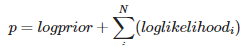

Note we calculate the prior from the training data, and that the training data is evenly split between positive and negative labels (4000 positive and 4000 negative tweets). This means that the ratio of positive to negative 1, and the logprior is 0

The value of 0.0 means that when we add the logprior to the log likelihood, we're just adding zero to the log likelihood. However, please remember to include the logprior, because whenever the data is not perfectly balanced, the logprior will be a non-zero value.

In [57]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    
    # Process the tweet to get a list of words
    word_1 = process_tweet(tweet)
    
    # Initialize probability to zero
    p = 0
    
    # Add logprior
    p += logprior
    
    for word in word_1:
        # Check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # Add the log likelihood of that word to the probability
            p += loglikelihood[word]
            
    return p

In [58]:
my_tweet = 'she smiled.'
p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print("The expected output is:", p)

The expected output is: 0.004169872743391509


**Test_naive_bayes**

Instructions:

Implement test_naive_bayes to check the accuracy of your predictions.

The function takes in your test_x, test_y, log_prior, and loglikelihood.

It returns the accuracy of your model.

First, use naive_bayes_predict function to make predictions for each tweet in text_x.

In [59]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of tweets
        test_y: the corresponding labels for the list of tweets
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of tweets classified correctly)/(total # of tweets)
    """
    
    accuracy = 0
    y_hats = []
    
    for tweet in test_x:
        # If the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # The predicted class is 1
            y_hat_i = 1
        else:
            y_hat_i = 0
            
        y_hats.append(y_hat_i)
        
        
    # error is the average of the absolute values of the differences between y_hats and test_y
    error = sum(test_y - y_hats)/len(test_y)
    
    # Accuracy is 1 minus the error
    accuracy = 1 - error
    
    return accuracy

In [60]:
print("Naive Bayes accuracy = %0.4f" %
      (test_naive_bayes(test_x, test_y, logprior, loglikelihood)))

Naive Bayes accuracy = 0.9970


In [61]:
# Run this cell to test your function
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    # print( '%s -> %f' % (tweet, naive_bayes_predict(tweet, logprior, loglikelihood)))
    p = naive_bayes_predict(tweet, logprior, loglikelihood)
#     print(f'{tweet} -> {p:.2f} ({p_category})')
    print(f'{tweet} -> {p:.2f}')

I am happy -> 0.02
I am bad -> -0.00
this movie should have been great. -> 0.01
great -> 0.01
great great -> 0.03
great great great -> 0.04
great great great great -> 0.05


**Part 4: Filter words by Ratio of positive to negative counts**

1. Some words have more positive counts than others, and can be considered "more positive". Likewise, some words can be considered more negative than others.

One way for us to define the level of positiveness or negativeness, without calculating the log likelihood, is to compare the positive to negative frequency of the word.

We can calculate the ratio of positive to negative frequencies of a word.

Once we're able to calculate these ratios, we can also filter a subset of words that have a minimum ratio of positivity / negativity or higher.

Similarly, we can also filter a subset of words that have a maximum ratio of positivity / negativity or lower (words that are at least as negative, or even more negative than a given threshold).



Given the freqs dictionary of words and a particular word, use lookup(freqs,word,1) to get the positive count of the word.

Similarly, use the lookup() function to get the negative count of that word.

Calculate the ratio of positive divided by negative counts


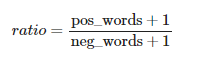

In [76]:
def get_ratio(freqs, word):
    '''
    Input:
        freqs: dictionary containing the words
        word: string to lookup

    Output: a dictionary with keys 'positive', 'negative', and 'ratio'.
        Example: {'positive': 10, 'negative': 20, 'ratio': 0.5}
    '''
    pos_neg_ratio = {'positive':0, 'negative':0, 'ratio':0.0}
    
    # Use lookup() to find positive counts for the word 
    pos_neg_ratio['positive'] = lookup(freqs,word,1)
    pos_neg_ratio['negative'] = lookup(freqs,word,0)
    pos_neg_ratio['ratio'] = (pos_neg_ratio['positive'] + 1)/(pos_neg_ratio['negative'] + 1)
    
    return pos_neg_ratio

In [ ]:
get_ratio(freqs, 'happi')()

**Implement get_words_by_threshold(freqs,label,threshold)**


In [79]:
def get_words_by_threshold(freqs, label, threshold):
    '''
    Input:
        freqs: dictionary of words
        label: 1 for positive, 0 for negative
        threshold: ratio that will be used as the cutoff for including a word in the returned dictionary
    Output:
        word_set: dictionary containing the word and information on its positive count, negative count, and ratio of positive to negative counts.
        example of a key value pair:
        {'happi':
            {'positive': 10, 'negative': 20, 'ratio': 0.5}
        }
    '''
    word_list = {}
    ###
    for key in freqs.keys():
        word, _ = key
        
        # Get the positive/negative ratio for a word
        pos_neg_ratio = get_ratio(freqs, word)
        
        # If the label is 1 and the ratio is greater than or equal to the threshold
        if label == 1 and pos_neg_ratio['ratio'] >= threshold:
               word_list[word] =  pos_neg_ratio
               
        elif label == 0 and pos_neg_ratio['ratio'] <= threshold:
            word_list[word] = pos_neg_ratio
    
    return word_list

In [80]:
# Test your function: find negative words at or below a threshold
get_words_by_threshold(freqs, label=0, threshold=0.05)

{':(': {'positive': 1, 'negative': 3663, 'ratio': 0.0005458515283842794},
 ':-(': {'positive': 0, 'negative': 378, 'ratio': 0.002638522427440633},
 'zayniscomingbackonjuli': {'positive': 0, 'negative': 19, 'ratio': 0.05},
 '26': {'positive': 0, 'negative': 20, 'ratio': 0.047619047619047616},
 '>:(': {'positive': 0, 'negative': 43, 'ratio': 0.022727272727272728},
 'lost': {'positive': 0, 'negative': 19, 'ratio': 0.05},
 '‚ôõ': {'positive': 0, 'negative': 210, 'ratio': 0.004739336492890996},
 '„Äã': {'positive': 0, 'negative': 210, 'ratio': 0.004739336492890996},
 'beliÃáev': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'wiÃáll': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'justiÃán': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'ÔΩìÔΩÖÔΩÖ': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'ÔΩçÔΩÖ': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776}}

In [81]:
# Test your function; find positive words at or above a threshold
get_words_by_threshold(freqs, label=1, threshold=10)

{'followfriday': {'positive': 23, 'negative': 0, 'ratio': 24.0},
 'commun': {'positive': 27, 'negative': 1, 'ratio': 14.0},
 ':)': {'positive': 2847, 'negative': 2, 'ratio': 949.3333333333334},
 'flipkartfashionfriday': {'positive': 16, 'negative': 0, 'ratio': 17.0},
 ':d': {'positive': 498, 'negative': 0, 'ratio': 499.0},
 ':p': {'positive': 104, 'negative': 0, 'ratio': 105.0},
 'influenc': {'positive': 16, 'negative': 0, 'ratio': 17.0},
 ':-)': {'positive': 543, 'negative': 0, 'ratio': 544.0},
 "here'": {'positive': 20, 'negative': 0, 'ratio': 21.0},
 'youth': {'positive': 14, 'negative': 0, 'ratio': 15.0},
 'bam': {'positive': 44, 'negative': 0, 'ratio': 45.0},
 'warsaw': {'positive': 44, 'negative': 0, 'ratio': 45.0},
 'shout': {'positive': 11, 'negative': 0, 'ratio': 12.0},
 ';)': {'positive': 22, 'negative': 0, 'ratio': 23.0},
 'stat': {'positive': 51, 'negative': 0, 'ratio': 52.0},
 'arriv': {'positive': 57, 'negative': 4, 'ratio': 11.6},
 'via': {'positive': 60, 'negative': 1, 

**Part 5: Error Analysis**

In this part you will see some tweets that your model missclassified. Why do you think the misclassifications happened? Were there any assumptions made by the naive bayes model?

In [ ]:
# Some error analysis done for you
print('Truth Predicted Tweet')
for x, y in zip(test_x, test_y):
    y_hat = naive_bayes_predict(x, logprior, loglikelihood)
    if y != (np.sign(y_hat) > 0):
        print('%d\t%0.2f\t%s' % (y, np.sign(y_hat) > 0, ' '.join(
            process_tweet(x)).encode('ascii', 'ignore')))

**Part 6: Predict with your own tweet**


In [ ]:
# Test with your own tweet - feel free to modify `my_tweet`
my_tweet = 'I am happy because I am learning :)'

p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print(p)